<img src="https://docs.dask.org/en/stable/_images/dask_icon.svg" width="15%" height="15%" align="left"/>

# Dask: Lazy Data Loading

In this example, we open a remote OME-Zarr and apply some basic transformatios to the data.
We'll see the benefits of lazy loading to only transfer the data that's needed.

In [1]:
import ngff_zarr as nz
import matplotlib.pyplot as plt
import numpy as np
import dask
from IPython.display import display, HTML

The webknossos zarr gallery ([zarr.webknossos.org](https://zarr.webknossos.org)) provides a number of large datasets in OME-Zarr format.

For a first pass, we'll choose one at less-than-random, "A Connectome of the Adult Drosophila Central Brain" [10.1101/2020.01.21.911859](https://www.biorxiv.org/content/10.1101/2020.01.21.911859v1).

In [2]:
# Let's open the data with ngff_zarr
flyem_em_url = "https://data-humerus.webknossos.org/data/zarr3_experimental/6128c212010000a100ca0fd6/emdata"
flyem_seg_url = "https://data-humerus.webknossos.org/data/zarr3_experimental/6128c212010000a100ca0fd6/segmentation_v1_2"
flyem_em = nz.from_ngff_zarr(flyem_em_url)
flyem_seg = nz.from_ngff_zarr(flyem_seg_url)

In [3]:
# What's it look like?
flyem_em.images[0].data

dask.array<from-zarr, shape=(1, 34427, 39725, 41394), dtype=uint8, chunksize=(1, 32, 32, 32), chunktype=numpy.ndarray>

In [4]:
# ...and segmentation
flyem_seg.images[0].data

dask.array<from-zarr, shape=(1, 34432, 39552, 41408), dtype=uint64, chunksize=(1, 32, 32, 32), chunktype=numpy.ndarray>

In [5]:
# It's OME, right? I can figure out the resolution & size of each scale
for dataset in flyem_em.metadata.datasets:
    print(dataset.coordinateTransformations)

[Scale(scale=[1, 8, 8, 8], type='scale')]
[Scale(scale=[1, 16, 16, 16], type='scale')]
[Scale(scale=[1, 32, 32, 32], type='scale')]
[Scale(scale=[1, 64, 64, 64], type='scale')]
[Scale(scale=[1, 128, 128, 128], type='scale')]
[Scale(scale=[1, 256, 256, 256], type='scale')]
[Scale(scale=[1, 512, 512, 512], type='scale')]
[Scale(scale=[1, 1024, 1024, 1024], type='scale')]
[Scale(scale=[1, 2048, 2048, 2048], type='scale')]


In [6]:
# Check the size at the most zoomed out scale
flyem_em.images[-1].data.shape

(1, 134, 155, 161)

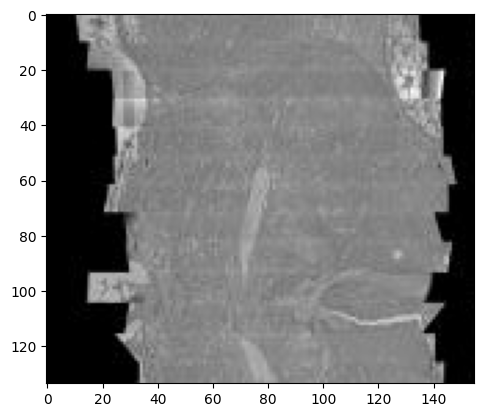

In [7]:
# Maybe a quick view of a 2D plane all the way zoomed out?
crop = flyem_em.images[-1].data[0,:,:,100].compute()
plt.imshow(crop, cmap='gray', vmin=0, vmax=255)
plt.show()

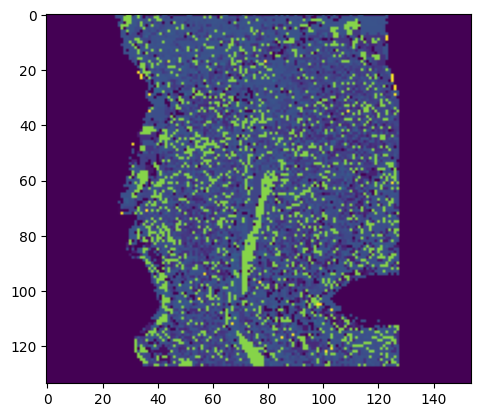

In [8]:
# ... and the segmentation layer?
crop = flyem_seg.images[-1].data[0,:,:,100].compute()
plt.imshow(crop)
plt.show()

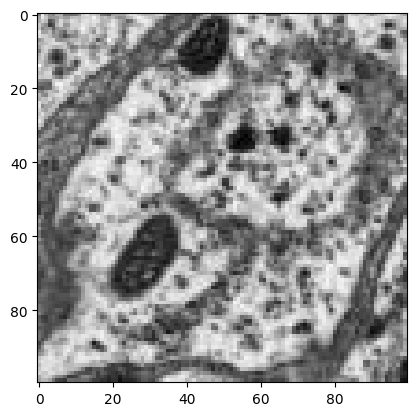

In [9]:
# ...and a zoomed in crop...
crop_em = flyem_em.images[2].data[0, 5000:5100, 5000:5100, 1000].compute()
plt.imshow(crop_em, cmap='gray', vmin=0, vmax=255)
plt.show()

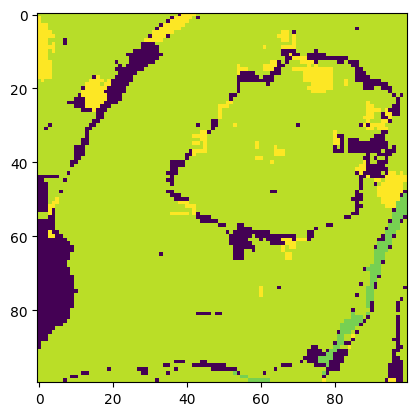

In [10]:
# And the labels...
crop_label = flyem_seg.images[2].data[0, 5000:5100, 5000:5100, 1000].compute()
plt.imshow(crop_label)
plt.show()

In [11]:
# Get the value of the segment in the midle...
my_pet_segment = crop_label[50,50]
my_pet_segment

np.uint64(264162026)

## Task: Mask a segment and cut it out from the EM volume

Taking advantage of dask lazy computation, we can define the task then generate the output.

In [12]:
# Crop the same region from both the labels & image data
crop_label = flyem_seg.images[2].data[0, 5000:5100, 5000:5100, 950:1050]
crop_em = flyem_em.images[2].data[0, 5000:5100, 5000:5100, 950:1050]

In [13]:
# Continue by 
crop_em_masked = dask.array.where(crop_label != my_pet_segment, 0, crop_em)

In [14]:
# But we haven't actually fetched data or done the computation yet#
# This will show us the computation planned...
crop_em_masked.dask

HighLevelGraph with 8 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x10f5d7c40>
 0. original-from-zarr-80ea1df75d6bc617ba70dbe8d667263e
 1. from-zarr-80ea1df75d6bc617ba70dbe8d667263e
 2. getitem-5e6b57b38a7f5a082dd412b905aa6c55
 3. original-from-zarr-293801d85f58cb53914823b8b0b54d1d
 4. from-zarr-293801d85f58cb53914823b8b0b54d1d
 5. getitem-41c1413715130e7c2a72f35064d74aaf
 6. ne-38af4dbcc94a9dc9bb84f4369558c020
 7. where-8fe56e3587963c551b901792bb596cdc

In [15]:
# Perform the actual compute...
cropped_masked_em = crop_em_masked.compute()

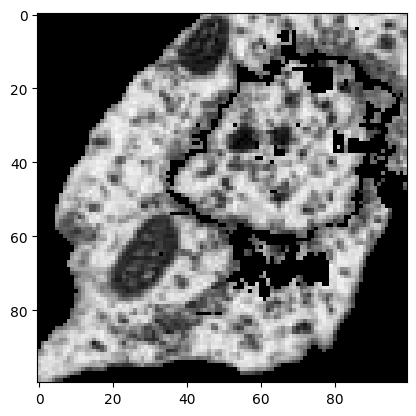

In [16]:
# View a plane in the middle as a sanity check
plt.imshow(cropped_masked_em[:,:,50], cmap='gray', vmin=0, vmax=255)
plt.show()

In [17]:
# Create a ngff-zarr object & multiscale
image = nz.to_ngff_image(cropped_masked_em, dims=['z','y','x'])
# Create a multiscales version
multiscale_image = nz.to_multiscales(image,
                                scale_factors=[2,4],
                                chunks=64)

In [18]:
# ...and save it
gcs_path = "gs://ome-2025-test-data/ex1/out/flyem-crop.zarr"
print(f"Saving ngff to {gcs_path} ...")
nz.to_ngff_zarr(gcs_path,
                multiscale_image, chunks_per_shard=8,
                version="0.5")
print("Done.")

Saving ngff to gs://ome-2025-test-data/ex1/out/flyem-crop.zarr ...
Done.


In [19]:
# ... and view it!
https_url = gcs_path.replace("gs://", "https://storage.googleapis.com/")
validator_url = f"https://ome.github.io/ome-ngff-validator/?source={https_url}"
display(HTML(f'<a href="{validator_url}">View NGFF Validator</a>'))